# Logistic Regression Models
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [110]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,auc,roc_curve,recall_score, f1_score, precision_score


In [111]:
#Importing the Data
data = pd.read_csv('creditcard.csv')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Regularize Features & Data Prep

In [113]:
#Scaling amount 
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [114]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#check distributions of data
fraud_train_pct = y_train[y_train== 1].value_counts()/len(y_train)*100
fraud_test_pct = y_test[y_test == 1].value_counts()/len(y_test)*100

print('Training set frauds:', round(fraud_train_pct[1], 2), '%')
print('Test set frauds:', round(fraud_test_pct[1], 2), '%')

Training set frauds: 0.17 %
Test set frauds: 0.17 %


#### Undersample the Training Set to Balance the Classes

In [115]:
#find instances of fraud in training set
train_fraud_indices = np.array(y_train[y_train== 1].index)
n_train_fraud = len(train_fraud_indices)
train_nonfraud_indices = np.array(y_train[y_train== 0].index)

#Randomly select number of non-fraud transactions to match the number of fraud transactions
random_indices = np.random.choice(train_nonfraud_indices, n_train_fraud, replace = False)
undersample_indices = np.concatenate([train_fraud_indices, random_indices])

#Resample the training data
x_train_u  = x_train.loc[undersample_indices]
y_train_u = y_train.loc[undersample_indices]

#Check the new distribution of data
fraud_train_pct_u = y_train_u[y_train_u== 1].value_counts()/len(y_train_u)*100
nonfraud_train_pct_u = y_train_u[y_train_u== 0].value_counts()/len(y_train_u)*100
print('Training set frauds:', round(fraud_train_pct_u[1], 2), '%')
print('Training set non-frauds:', round(nonfraud_train_pct_u[0], 2), '%')

Training set frauds: 50.0 %
Training set non-frauds: 50.0 %


##### Cross Validation for Logisitc Regression Hyperparameter Selection

In [116]:
#Create function for logisitic regression k_fold cross validation
def lr_kfold_cv(x_train,y_train,k):
    k_fold = KFold(n_splits = k, shuffle = True, random_state = 4)
    c = [0.01, 0.1, 1, 10, 100] #weight values to try
    scores = np.zeros(len(c))
    for i in range(len(c)):

        recall = np.zeros(k)
        precision = np.zeros(k)
        f1 = np.zeros(k)
        indx = 0
        for train_index, valid_index in k_fold.split(x_train):
            lr = LogisticRegression(C = c[i], penalty= "l2", max_iter= 500) #Logistic Regression model
            lr.fit(x_train.iloc[train_index], y_train.iloc[train_index]) #Fitting the model
            y_pred = lr.predict(x_train.iloc[valid_index]) #Predicting on the validation set

            #Evaluating the model
            recall[indx] = recall_score(y_train.iloc[valid_index], y_pred)
            precision[indx] = precision_score(y_train.iloc[valid_index], y_pred)
            f1[indx] = f1_score(y_train.iloc[valid_index], y_pred)
            indx += 1

        avg_recall = np.mean(recall)
        avg_precision = np.mean(precision)
        avg_f1 = np.mean(f1)
        scores[i] = avg_f1
        print('C =', c[i], ', Recall:', avg_recall, 'Precision:', avg_precision, 'F1:', avg_f1)

    #Select model with best F1 score
    c_val = c[np.argmax(scores)]
    print('Select', c_val, 'as the best C value')
    return c_val

#5 fold CV on Undersampled Dataset to select weight parameter
c = lr_kfold_cv(x_train_u, y_train_u, 5)

C = 0.01 , Recall: 0.861167527710216 Precision: 0.9728242533516367 F1: 0.9129727318567937
C = 0.1 , Recall: 0.903098869103627 Precision: 0.9714362840224909 F1: 0.9358025916804685
C = 1 , Recall: 0.9063246755552399 Precision: 0.9599429767600778 F1: 0.9315852103952829
C = 10 , Recall: 0.9123282597846305 Precision: 0.95363437052028 F1: 0.9323092006583524
C = 100 , Recall: 0.9058766468814048 Precision: 0.9535961344999219 F1: 0.928830625469298
Select 0.1 as the best C value


#### Training and Testing the Model

Actual Frauds: 148
Actual Non-Frauds: 85295
Probability of False Alarm: 0.02783281552259804
Probability of Missed Detection 0.16891891891891891
True Positive Rate: 0.831081081081081


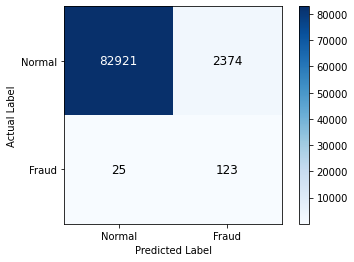

Recall: 0.831081081081081 Precision: 0.04925911093311974 F1: 0.09300567107750472


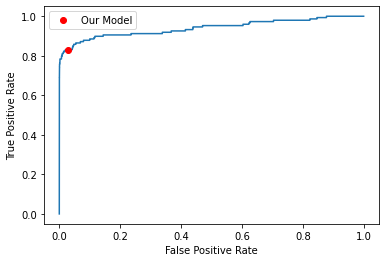

AUC: 0.9407085583737206


In [117]:
#Create model with best weight parameter
lr = LogisticRegression(C = c, penalty= "l2", max_iter= 500) #Logistic Regression model
lr.fit(x_train_u, y_train_u) #Fitting the model

#Predict on the (skewed) test set
y_pred = lr.predict(x_test) 


#Evaluate the model
#Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
fruads = y_test[y_test == 1]
print('Actual Frauds:', len(fruads))
non_fruads = y_test[y_test == 0]
print('Actual Non-Frauds:', len(non_fruads))

#Calculate metrics
pfa = cnf_matrix[0][1]/(len(non_fruads))
print('Probability of False Alarm:', pfa)
pmd = cnf_matrix[1][0]/(len(fruads))
print('Probability of Missed Detection', pmd)
trpr = cnf_matrix[1][1]/(len(fruads))
print('True Positive Rate:', trpr)

#Plot confusion matrix
fig = plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Fraud'])
plt.yticks(tick_marks, ['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.text(0, 0, '{}'.format(cnf_matrix[0,0]), ha='center', va='center', color='white', fontsize=12)
plt.text(1, 0, '{}'.format(cnf_matrix[0,1]), ha='center', va='center', color='black', fontsize=12)
plt.text(0, 1, '{}'.format(cnf_matrix[1,0]), ha='center', va='center', color='black', fontsize=12)
plt.text(1, 1, '{}'.format(cnf_matrix[1,1]), ha='center', va='center', color='black', fontsize=12)
plt.show()

#Precision and Recall and F1 Score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Recall:', recall, 'Precision:', precision, 'F1:', f1)

#Plot ROC curve
y_pred = lr.fit(x_train_u, y_train_u).decision_function(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
fig = plt.figure()
plt.plot(fpr, tpr)
plt.plot(pfa,trpr, 'ro', label = "Our Model")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC:', auc(fpr, tpr))

#### Model without Data Conditioning (for comparision)

Actual Frauds: 148
Actual Non-Frauds: 85295
Probability of False Alarm: 0.0001758602497215546
Probability of Missed Detection 0.40540540540540543
True Positive Rate: 0.5945945945945946


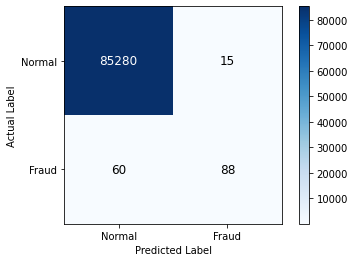

Recall: 0.5945945945945946 Precision: 0.8543689320388349 F1: 0.7011952191235059


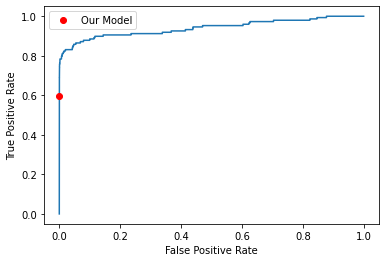

AUC: 0.9407085583737206


In [118]:
#use entire (unbalanced) training and testing set to evaluate model
lr = LogisticRegression(C = c, penalty= "l2", max_iter= 500) #Logistic Regression model
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)


#Evaluate the model
#Confusion Matrix
#Evaluate the model
#Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
fruads = y_test[y_test == 1]
print('Actual Frauds:', len(fruads))
non_fruads = y_test[y_test == 0]
print('Actual Non-Frauds:', len(non_fruads))

#Calculate metrics
pfa = cnf_matrix[0][1]/(len(non_fruads))
print('Probability of False Alarm:', pfa)
pmd = cnf_matrix[1][0]/(len(fruads))
print('Probability of Missed Detection', pmd)
trpr = cnf_matrix[1][1]/(len(fruads))
print('True Positive Rate:', trpr)

#Plot confusion matrix
fig = plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Fraud'])
plt.yticks(tick_marks, ['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.text(0, 0, '{}'.format(cnf_matrix[0,0]), ha='center', va='center', color='white', fontsize=12)
plt.text(1, 0, '{}'.format(cnf_matrix[0,1]), ha='center', va='center', color='black', fontsize=12)
plt.text(0, 1, '{}'.format(cnf_matrix[1,0]), ha='center', va='center', color='black', fontsize=12)
plt.text(1, 1, '{}'.format(cnf_matrix[1,1]), ha='center', va='center', color='black', fontsize=12)
plt.show()

#Precision and Recall and F1 Score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Recall:', recall, 'Precision:', precision, 'F1:', f1)

#Plot ROC curve
y_pred = lr.fit(x_train_u, y_train_u).decision_function(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)
fig = plt.figure()
plt.plot(fpr, tpr)
plt.plot(pfa,trpr, 'ro', label = "Our Model")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC:', auc(fpr, tpr))

Helpful code: https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now